# Primjer n>m, A ima izdvojene sv. vrij.

In [760]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from odmd import OnlineDMD
import time

In [761]:
#%run DMD_functions.ipynb
%run fDMD_functions.ipynb
%run Hemati_DMD_functions.ipynb
%run update-LQ.ipynb

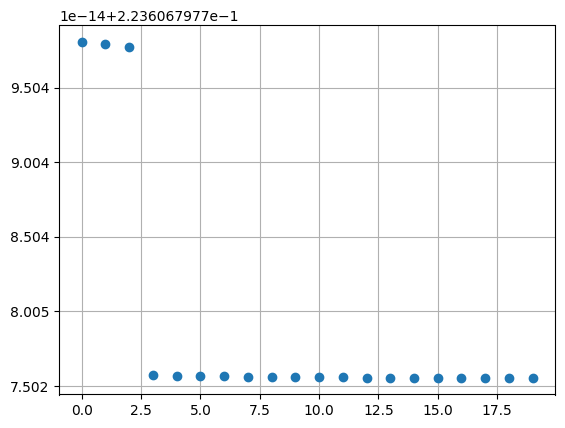

In [762]:
m=20
A = np.diag([10]*3+[10-1e-12]*(m-3))
A = A/np.linalg.norm(A)
U, _ = np.linalg.qr(np.random.standard_normal((m,m)))
V, _ = np.linalg.qr(np.random.standard_normal((m,m)))
A = U@A@(V.T)
#print(A)
#plt.imshow(A)
#plt.colorbar()

svdsA = np.linalg.svdvals(A)
plt.plot(svdsA, ls="", marker='o')
plt.grid()

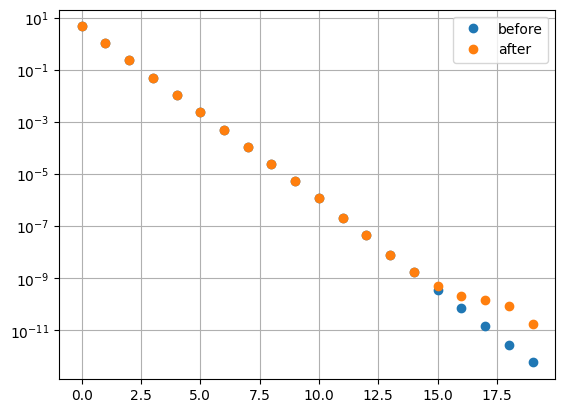

In [763]:
n=80
x = np.random.standard_normal((m, 1))
data = np.copy(x)
for i in range(n-1):
    y = A@(data[:, -1].reshape(-1,1))
    data = np.hstack((data, y))

svd_vals_bef = np.linalg.svdvals(data[:, :m])
data = data + np.random.standard_normal(data.shape)*(1e-10)
svd_vals_af = np.linalg.svdvals(data[:, :m])

plt.plot(svd_vals_bef, ls="", marker='o', label="before")
plt.plot(svd_vals_af, ls="", marker='o', label="after")
plt.grid()
plt.yscale('log')
plt.legend()


In [ ]:
#####################################################################################################


q = m 
kraj=60
t_pred=20

############################################################################################################
##          ZHANG

odmd = OnlineDMD(m, 1.0)
odmd.initialize(data[:, :q], data[:, 1:q+1])
start = time.time()
for k in range(q, kraj-1):
    odmd.update(data[:, k], data[:, k+1])
    
end = time.time()
print("Online DMD zhang, weighting = 1, time = " + str(end-start) + " secs")
#odmd.A = np.array(odmd.A, dtype="float32")
Lambda_z, Z_z = odmd.computemodes()

times = [i for i in range (kraj+t_pred)]

reconstructed_zhang_st = DMD_reconstruction(data[:,:kraj], Z_z, 'all', Lambda_z, times) #ako pokusam cijeli rekonstruirati - overflow - sv vrijednosti neke su vece od 1 pa je 10000-ti previse rekonstruirati (i puno prije toga)

#######################################################################################################
##      NAS


R, Q = scipy.linalg.rq(data[:,: q], mode="economic") #vraca R i Q^T
Rinv = np.linalg.inv(R)
Gyq = data[:, 1:q+1]@(Q.T)
del(Q)
start = time.time()
for k in range(q, kraj-1):
    Gyq, R, Rinv = YQL_Linv_update(Gyq, R, Rinv, data[:, k].reshape(-1,1), data[:, k+1].reshape(-1,1), upper=True)
end = time.time()
print("Online DMD nase, weighting = 1, time = " + str(end-start) + " secs")

#Lambda_nas, Z_nas  = np.linalg.eig(np.array((Gyq@Rinv), dtype="float32"))
Lambda_nas, Z_nas = np.linalg.eig(Gyq@Rinv)

reconstructed_nas_st = DMD_reconstruction(data[:,:kraj], Z_nas, 'all', Lambda_nas, times)

Online DMD zhang, weighting = 1, time = 0.00130462646484375 secs
Online DMD nase, weighting = 1, time = 0.0500333309173584 secs


In [765]:
greske_zhang = np.linalg.norm(reconstructed_zhang_st-data[:, times], axis=0)/np.linalg.norm(data[:, times], axis=0)
greske_nas = np.linalg.norm(reconstructed_nas_st - data[:, times], axis=0)/np.linalg.norm(data[:, times], axis=0)

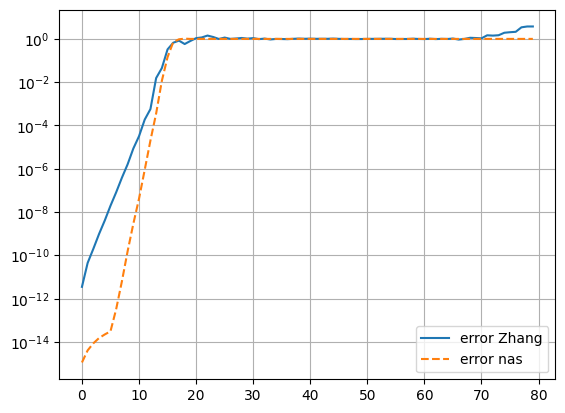

In [766]:
plt.plot(greske_zhang, label="error Zhang") 
plt.plot(greske_nas, label="error nas", ls="--")
plt.grid()
plt.legend()
plt.yscale('log')


In [ ]:
#####################################################################################################
q = 2*m 
#t_pred=20

############################################################################################################
##          ZHANG

odmd = OnlineDMD(m, 1.0)
odmd.initialize(data[:, :q], data[:, 1:q+1])

reconstructed_zhang = []
reconstructed_nas = []

for k in range(q, n-1):
    odmd.update(data[:, k], data[:, k+1])
    times = [k+1]
    Lambda_z, Z_z = odmd.computemodes()
    rec = DMD_reconstruction(data[:,:k+1], Z_z, 'all', Lambda_z, times)
    reconstructed_zhang.append(np.linalg.norm(rec-data[:,times])/np.linalg.norm(data[:, times]))



#######################################################################################################
##      NAS


R, Q = scipy.linalg.rq(data[:,: q], mode="economic") #vraca R i Q^T
Rinv = np.linalg.inv(R)
Gyq = data[:, 1:q+1]@(Q.T)
del(Q)
for k in range(q, n-1):
    Gyq, R, Rinv = YQL_Linv_update(Gyq, R, Rinv, data[:, k].reshape(-1,1), data[:, k+1].reshape(-1,1), upper=True)
    Lambda_nas, Z_nas = np.linalg.eig(Gyq@Rinv)
    rec = DMD_reconstruction(data[:,:k+1], Z_nas, 'all', Lambda_nas, times)
    reconstructed_nas.append(np.linalg.norm(rec-data[:,times])/np.linalg.norm(data[:, times]))



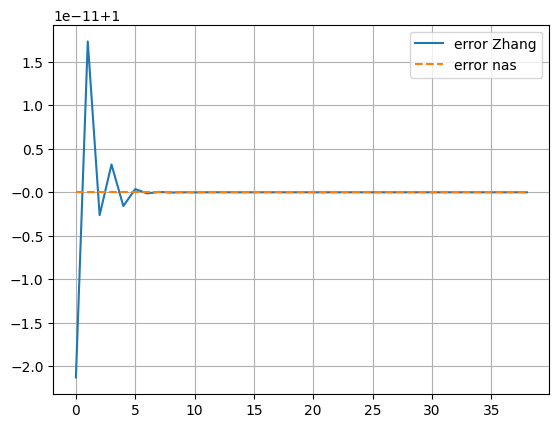

In [ ]:
plt.plot(reconstructed_zhang, label="error Zhang") 
plt.plot(reconstructed_nas, label="error nas", ls="--")
plt.grid()
plt.legend()
plt.yscale('log')
